# 파이토치 RNN 분류 모델
- 코드 출처: https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-09-17 14:12:47--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.45.116, 13.226.45.16, 13.226.45.35, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.45.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  17.8MB/s    in 0.2s    

2020-09-17 14:12:47 (17.8 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Ital

이름: Ślusàrski

In [7]:
from io import open
import glob
import os

def findFiles(path):
  return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD',s)
      if unicodedata.category(c) != 'Mn' and c in all_letters
      )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_category = []

def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_category.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_category)

['data/names/Portuguese.txt', 'data/names/Polish.txt', 'data/names/Russian.txt', 'data/names/Vietnamese.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Czech.txt', 'data/names/Arabic.txt', 'data/names/Dutch.txt']
Slusarski


In [9]:
print(category_lines['Korean'][:5])

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [12]:
import torch

def letterToIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 신경망 생성

- 모델 생성 방법 참고 : https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html

In [14]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

In [17]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9365, -2.9703, -2.8938, -2.9023, -2.8371, -2.9144, -2.8450, -2.9212,
         -2.9120, -2.8736, -2.8731, -2.8853, -2.8691, -2.9273, -2.8457, -2.8041,
         -2.8754, -2.9566]], grad_fn=<LogSoftmaxBackward>)


In [19]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9365, -2.9703, -2.8938, -2.9023, -2.8371, -2.9144, -2.8450, -2.9212,
         -2.9120, -2.8736, -2.8731, -2.8853, -2.8691, -2.9273, -2.8457, -2.8041,
         -2.8754, -2.9566]], grad_fn=<LogSoftmaxBackward>)


## 모델 학습
- 준비

In [21]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_category[category_i], category_i

print(categoryFromOutput(output))

('Czech', 15)


In [25]:
import random
def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_category)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_category.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category: {} \t line: {}'.format(category, line))

category: Arabic 	 line: Mustafa
category: German 	 line: Leverenz
category: Dutch 	 line: Rompaye
category: Greek 	 line: Arvanitoyannis
category: Russian 	 line: Belousov
category: Polish 	 line: Slusarczyk
category: Japanese 	 line: Mitsuharu
category: Italian 	 line: Confortola
category: Russian 	 line: Holminov
category: Japanese 	 line: Kitagawa


## 손실함수

In [26]:
criterion = nn.NLLLoss()

## 모델 학습

In [27]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()
  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000
current_loss = 0
all_losses = []

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m *60
  return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '0' if guess == category else 'X (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter/n_iters * 100,timeSince(start), loss, line, guess,correct))
  
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 6s) 2.7688 Kreisinger / Greek X (Czech)
10000 10% (0m 12s) 1.3778 Rhee / Korean 0
15000 15% (0m 19s) 0.9221 Yau / Chinese 0
20000 20% (0m 25s) 4.2849 Auttenberg / Dutch X (Polish)
25000 25% (0m 31s) 1.1540 Vinci / Italian 0
30000 30% (0m 37s) 1.8117 Tremble / Scottish X (French)
35000 35% (0m 43s) 2.0912 Wirth / English X (German)
40000 40% (0m 50s) 0.1384 Kaminaga / Japanese 0
45000 45% (0m 56s) 1.2527 Nosek / Arabic X (Polish)
50000 50% (1m 2s) 3.4919 Poingdestre / Dutch X (French)
55000 55% (1m 8s) 0.9107 Siew / Chinese 0
60000 60% (1m 14s) 2.1379 Nam / Vietnamese X (Korean)
65000 65% (1m 21s) 2.6959 Jmudsky / Polish X (Russian)
70000 70% (1m 27s) 1.4147 Mullins / English 0
75000 75% (1m 33s) 2.1529 Vipond / English X (French)
80000 80% (1m 39s) 1.2004 Okano / Japanese 0
85000 85% (1m 45s) 0.1778 Angelopoulos / Greek 0
90000 90% (1m 52s) 4.1958 Bellandini / Russian X (Italian)
95000 95% (1m 58s) 0.1484 Yau / Chinese 0
100000 100% (2m 4s) 0.5250 Xie / Chinese 0


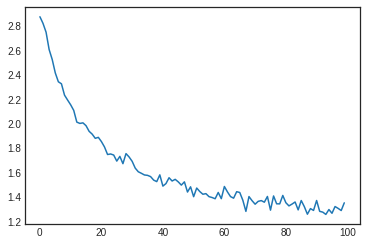

In [30]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.figure()
plt.plot(all_losses)
plt.show()

## 모델 테스트

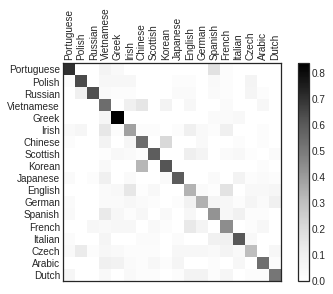

In [34]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000
def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_category.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_category, rotation=90)
ax.set_yticklabels([''] + all_category)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## 사용자 입력으로부터의 실행

In [40]:
def predict(input_line, n_predictions=3):
  print('\n> %s' % input_line)
  with torch.no_grad():
    output = evaluate(lineToTensor(input_line))
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
      value = topv[0][i].item()
      category_index = topi[0][i].item()
      print('(%.2f) %s'% (value, all_category[category_index]))
      predictions.append([value, all_category[category_index]])

predict('Jackson')
predict('Bill')
predict('Dovesky')
predict('Kim')
predict('Yeon')


> Jackson
(-0.31) Scottish
(-1.80) English
(-3.65) Dutch

> Bill
(-1.39) Irish
(-1.55) English
(-2.24) German

> Dovesky
(-0.68) Czech
(-0.90) Russian
(-3.03) English

> Kim
(-1.37) Korean
(-1.57) Chinese
(-2.04) Russian

> Yeon
(-0.61) Korean
(-1.34) Chinese
(-3.06) English
